In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [35]:
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [37]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [38]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()

In [39]:
# Crear transformador para números y categorías
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [40]:
# Pipeline con PCA
pca = PCA(n_components=2)
pipeline = Pipeline([('preprocessor', preprocessor), ('pca', pca)])

In [41]:
# Transformar datos
X_pca = pipeline.fit_transform(df)

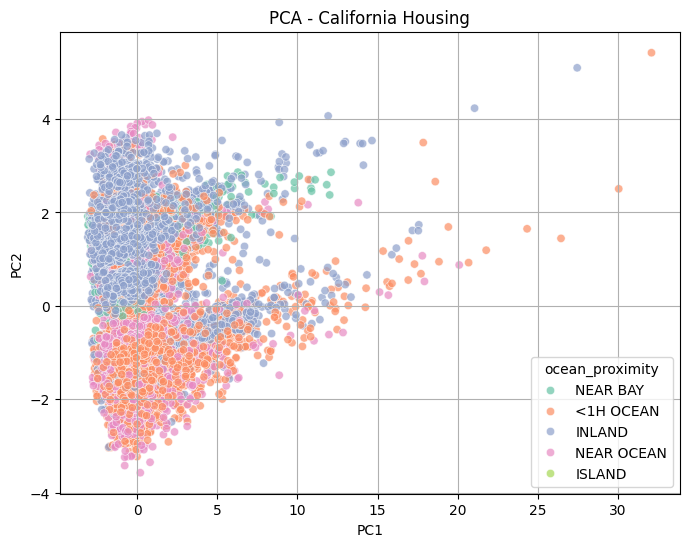

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], alpha=0.7, hue=df['ocean_proximity'], palette='Set2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - California Housing')
plt.grid(True)
plt.show()

In [48]:
# Varianza explicada
print('Varianza explicada', pca.explained_variance_ratio_)
print('Varianza acumulada', pca.explained_variance_ratio_.sum())


Varianza explicada [0.41445206 0.20791396]
Varianza acumulada 0.6223660126351356


In [49]:
# Obtener nombres finales de las columnas después del OneHotEncoding
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# DataFrame con las cargas del PCA
loadings_df = pd.DataFrame(
    pipeline.named_steps['pca'].components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

# Ordenar por contribución absoluta a PC1 y PC2
top_pc1 = loadings_df['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings_df['PC2'].abs().sort_values(ascending=False).head(10)

print("🔹 Top variables que más influyen en PC1:")
print(top_pc1)

print("\n🔹 Top variables que más influyen en PC2:")
print(top_pc2)

🔹 Top variables que más influyen en PC1:
num__households                  0.490917
num__total_bedrooms              0.488562
num__total_rooms                 0.484608
num__population                  0.470317
num__housing_median_age          0.216881
num__longitude                   0.076700
num__latitude                    0.076633
num__median_income               0.056242
num__median_house_value          0.045932
cat__ocean_proximity_NEAR BAY    0.013413
Name: PC1, dtype: float64

🔹 Top variables que más influyen en PC2:
num__latitude                    0.677485
num__longitude                   0.635502
num__median_house_value          0.233704
num__median_income               0.212035
cat__ocean_proximity_INLAND      0.115784
cat__ocean_proximity_NEAR BAY    0.080063
num__total_bedrooms              0.073491
num__households                  0.071992
num__total_rooms                 0.057768
num__population                  0.049537
Name: PC2, dtype: float64


In [52]:
# Como ocean_proximity tiene 5 categorías:
numero_clusters = df['ocean_proximity'].nunique()

kmeans = KMeans(n_clusters=numero_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [53]:
# Añadir clusters al dataframe
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

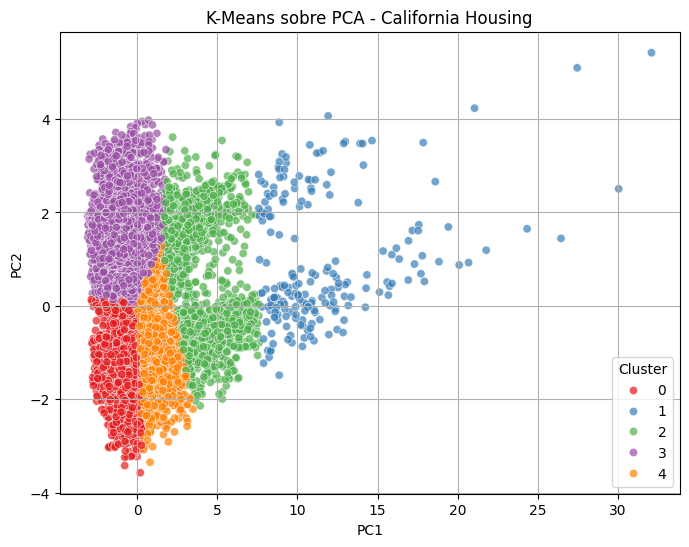

In [55]:
# Construyo un DF para graficar ordenado
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,  # salida de KMeans
    'ocean_proximity': df['ocean_proximity'].values
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('K-Means sobre PCA - California Housing')
plt.grid(True)
plt.show()

In [56]:
pd.crosstab(plot_df['Cluster'], plot_df['ocean_proximity'])

ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
Cluster,,,,,
0,4662,1184,5,33,1106
1,90,82,0,14,19
2,659,583,0,185,156
3,1302,3910,0,2034,703
4,2423,792,0,24,674


In [58]:
le = LabelEncoder()
true_labels = le.fit_transform(plot_df['ocean_proximity'])
ari = adjusted_rand_score(true_labels, plot_df['Cluster'])
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.125


In [60]:
# 1. PCA con más componentes
pca_opt = PCA(n_components=6)  # ajusta según varianza acumulada deseada
X_pca_opt = pca_opt.fit_transform(pipeline.named_steps['preprocessor'].fit_transform(df))

# 2. Probar distintos números de clusters
scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca_opt)
    sil = silhouette_score(X_pca_opt, labels)
    scores[k] = sil

# Mostrar mejor número de clusters
best_k = max(scores, key=scores.get)
print("Mejor número de clusters según silhouette:", best_k)

# 3. Reentrenar KMeans con mejor K
kmeans_opt = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_opt = kmeans_opt.fit_predict(X_pca_opt)

# 4. ARI con etiquetas reales
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

le = LabelEncoder()
true_labels = le.fit_transform(df['ocean_proximity'])
ari_new = adjusted_rand_score(true_labels, clusters_opt)
print(f"ARI nuevo: {ari_new:.3f} (antes era 0.125)")


Mejor número de clusters según silhouette: 2
ARI nuevo: -0.007 (antes era 0.125)


In [61]:
# 1. Preprocesar datos (todas las variables escaladas y codificadas)
X_full = pipeline.named_steps['preprocessor'].fit_transform(df)

# 2. K-Means con K=5 (mismo número que categorías reales)
kmeans_full = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_full = kmeans_full.fit_predict(X_full)

# 3. Calcular ARI
le = LabelEncoder()
true_labels = le.fit_transform(df['ocean_proximity'])
ari_full = adjusted_rand_score(true_labels, clusters_full)
print(f"ARI usando todas las variables y K=5: {ari_full:.3f}")

# 4. Tabla de comparación
plot_df_full = pd.DataFrame({
    'Cluster': clusters_full,
    'ocean_proximity': df['ocean_proximity'].values
})
tabla = pd.crosstab(plot_df_full['Cluster'], plot_df_full['ocean_proximity'])
print(tabla)

ARI usando todas las variables y K=5: 0.131
ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
Cluster                                                         
0                     1671     180       0       465         550
1                      115     132       0        20          23
2                     1287     844       0       205         308
3                     1018    3636       0      1600         522
4                     5045    1759       5         0        1255


In [64]:
# 1. Preprocesar todas las variables (ya escaladas/codificadas con tu pipeline)
X_full = pipeline.named_steps['preprocessor'].fit_transform(df)

# 2. Escalar si no estaba hecho (DBSCAN es sensible a escalas)
# En este caso ya está escalado por StandardScaler en el pipeline

# 3. Probar DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)  # eps controla el tamaño del vecindario
clusters_db = dbscan.fit_predict(X_full)

# 4. Calcular ARI
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
true_labels = le.fit_transform(df['ocean_proximity'])
ari_db = adjusted_rand_score(true_labels, clusters_db)
print(f"ARI con DBSCAN: {ari_db:.3f}")

# 5. Tabla de comparación (solo para clusters >= 0, -1 son outliers)
plot_df_db = pd.DataFrame({
    'Cluster': clusters_db,
    'ocean_proximity': df['ocean_proximity'].values
})
tabla = pd.crosstab(plot_df_db['Cluster'], plot_df_db['ocean_proximity'])
print(tabla)

# 6. Cuántos clusters detectó
print(f"Número de clusters detectados (excluyendo -1): {len(set(clusters_db)) - (1 if -1 in clusters_db else 0)}")

ARI con DBSCAN: 0.001
ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
Cluster                                                         
-1                     116     123       0        35          51
 0                    9013    6425       5      2255        2606
 1                       7       3       0         0           1
Número de clusters detectados (excluyendo -1): 2


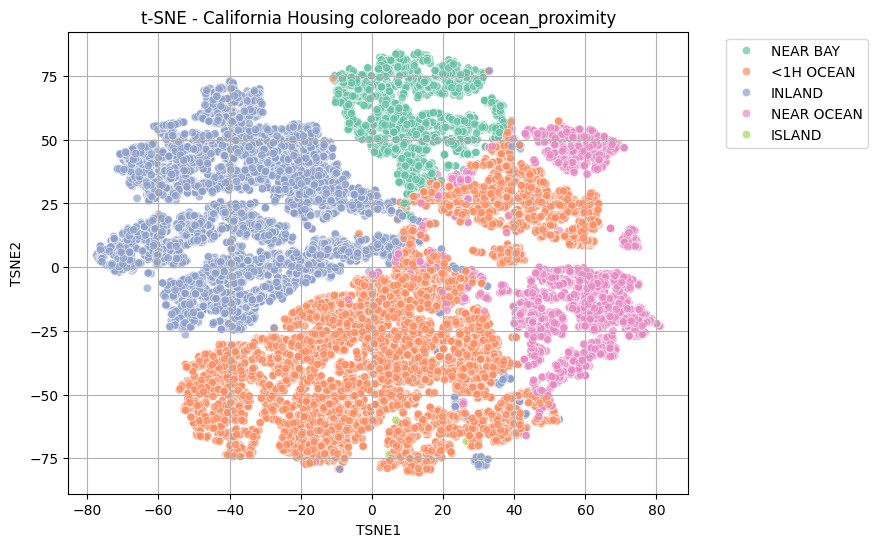

In [68]:
# 1. Preprocesar datos (ya escalados/codificados con el pipeline)
X_full = pipeline.named_steps['preprocessor'].fit_transform(df)

# 2. Aplicar t-SNE (reducir a 2 dimensiones)
tsne = TSNE(
    n_components=2, 
    perplexity=30,      # relación puntos-vecinos
    learning_rate=200, 
    random_state=42, 
    n_iter=1000
)
X_tsne = tsne.fit_transform(X_full)

# 3. DataFrame para graficar
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'ocean_proximity': df['ocean_proximity'].values
})

# 4. Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df, 
    x='TSNE1', 
    y='TSNE2', 
    hue='ocean_proximity', 
    palette='Set2', 
    alpha=0.7
)
plt.title('t-SNE - California Housing coloreado por ocean_proximity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

ARI con K-Means sobre t-SNE: 0.341
ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
row_0                                                           
0                     3762      94       5         0          60
1                        1    4367       0         0           2
2                     2744    1667       0         0           9
3                      977     384       0      2290         694
4                     1652      39       0         0        1893


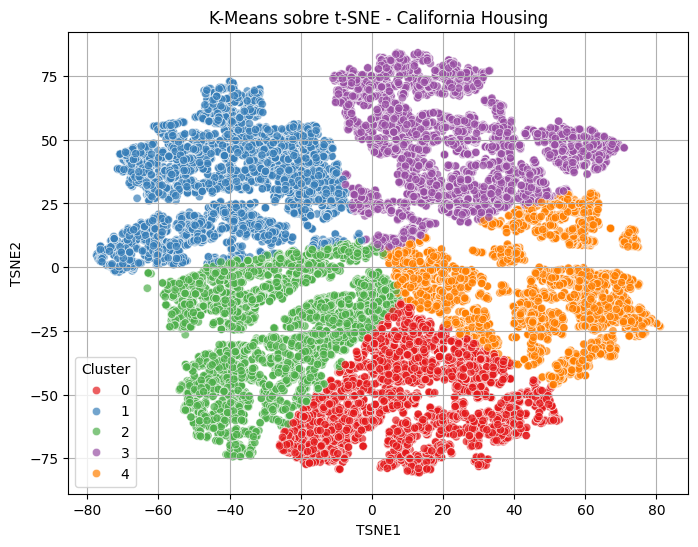

In [69]:
# 1. K-Means sobre t-SNE
n_clusters = df['ocean_proximity'].nunique()  # mismo nº de categorías reales
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_tsne = kmeans_tsne.fit_predict(X_tsne)

# 2. ARI contra etiquetas reales
le = LabelEncoder()
true_labels = le.fit_transform(df['ocean_proximity'])
ari_tsne = adjusted_rand_score(true_labels, clusters_tsne)
print(f"ARI con K-Means sobre t-SNE: {ari_tsne:.3f}")

# 3. Tabla de contingencia
tabla_tsne = pd.crosstab(clusters_tsne, df['ocean_proximity'])
print(tabla_tsne)

# 4. Visualización de clusters de K-Means sobre t-SNE
tsne_cluster_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'Cluster': clusters_tsne
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_cluster_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('K-Means sobre t-SNE - California Housing')
plt.grid(True)
plt.show()

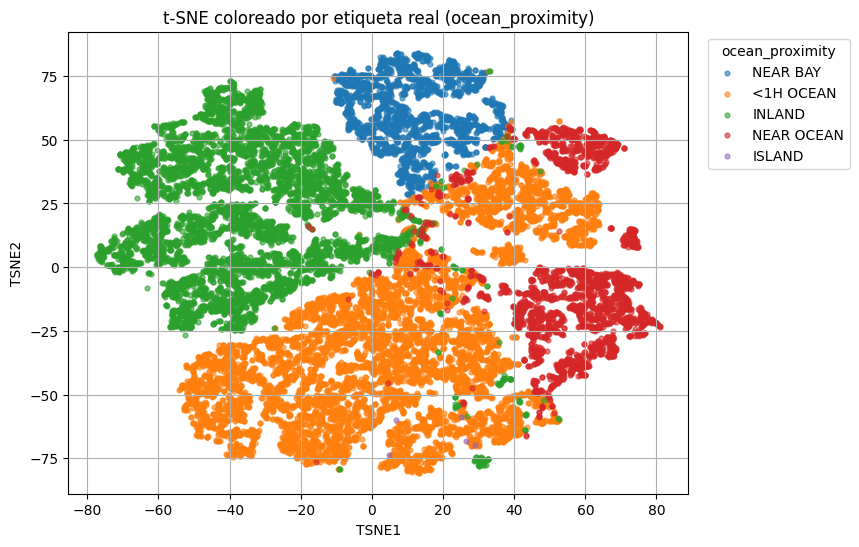

In [70]:
plt.figure(figsize=(8,6))
for cat in df['ocean_proximity'].unique():
    mask = (df['ocean_proximity'] == cat).values
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], alpha=0.6, label=str(cat), s=12)

plt.title('t-SNE coloreado por etiqueta real (ocean_proximity)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.legend(title='ocean_proximity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

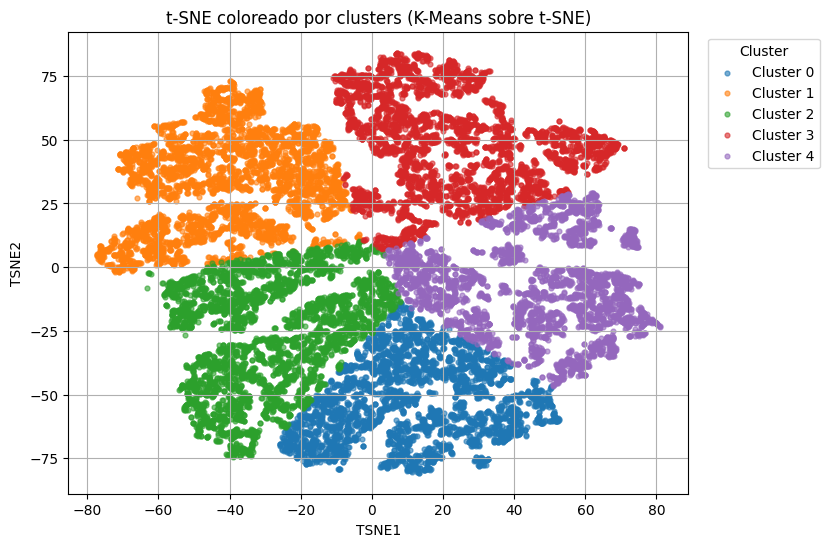

In [71]:
plt.figure(figsize=(8,6))
for cl in np.unique(clusters_tsne):
    mask = (clusters_tsne == cl)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], alpha=0.6, label=f'Cluster {cl}', s=12)

plt.title('t-SNE coloreado por clusters (K-Means sobre t-SNE)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

In [72]:
# para buscar mejores parámetros
perplexities = [10, 20, 30, 40, 50]
learning_rates = [100, 200, 300, 500]
results = []

X_full = pipeline.named_steps['preprocessor'].fit_transform(df)
true_labels = LabelEncoder().fit_transform(df['ocean_proximity'])

for perp in perplexities:
    for lr in learning_rates:
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=42, n_iter=1000)
        X_tsne_opt = tsne.fit_transform(X_full)

        # K-Means sobre t-SNE
        kmeans = KMeans(n_clusters=df['ocean_proximity'].nunique(), random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_tsne_opt)

        ari = adjusted_rand_score(true_labels, clusters)
        results.append((perp, lr, ari))
        print(f"perplexity={perp}, learning_rate={lr} -> ARI={ari:.3f}")

# Mejor combinación
best_params = max(results, key=lambda x: x[2])
print("\nMejores parámetros:", best_params)

perplexity=10, learning_rate=100 -> ARI=0.371
perplexity=10, learning_rate=200 -> ARI=0.352
perplexity=10, learning_rate=300 -> ARI=0.345
perplexity=10, learning_rate=500 -> ARI=0.365
perplexity=20, learning_rate=100 -> ARI=0.385
perplexity=20, learning_rate=200 -> ARI=0.386
perplexity=20, learning_rate=300 -> ARI=0.387
perplexity=20, learning_rate=500 -> ARI=0.400
perplexity=30, learning_rate=100 -> ARI=0.415
perplexity=30, learning_rate=200 -> ARI=0.341
perplexity=30, learning_rate=300 -> ARI=0.411
perplexity=30, learning_rate=500 -> ARI=0.419
perplexity=40, learning_rate=100 -> ARI=0.355
perplexity=40, learning_rate=200 -> ARI=0.369
perplexity=40, learning_rate=300 -> ARI=0.366
perplexity=40, learning_rate=500 -> ARI=0.406
perplexity=50, learning_rate=100 -> ARI=0.359
perplexity=50, learning_rate=200 -> ARI=0.401
perplexity=50, learning_rate=300 -> ARI=0.408
perplexity=50, learning_rate=500 -> ARI=0.414

Mejores parámetros: (30, 500, 0.41927256201081103)


ARI con t-SNE optimizado: 0.419


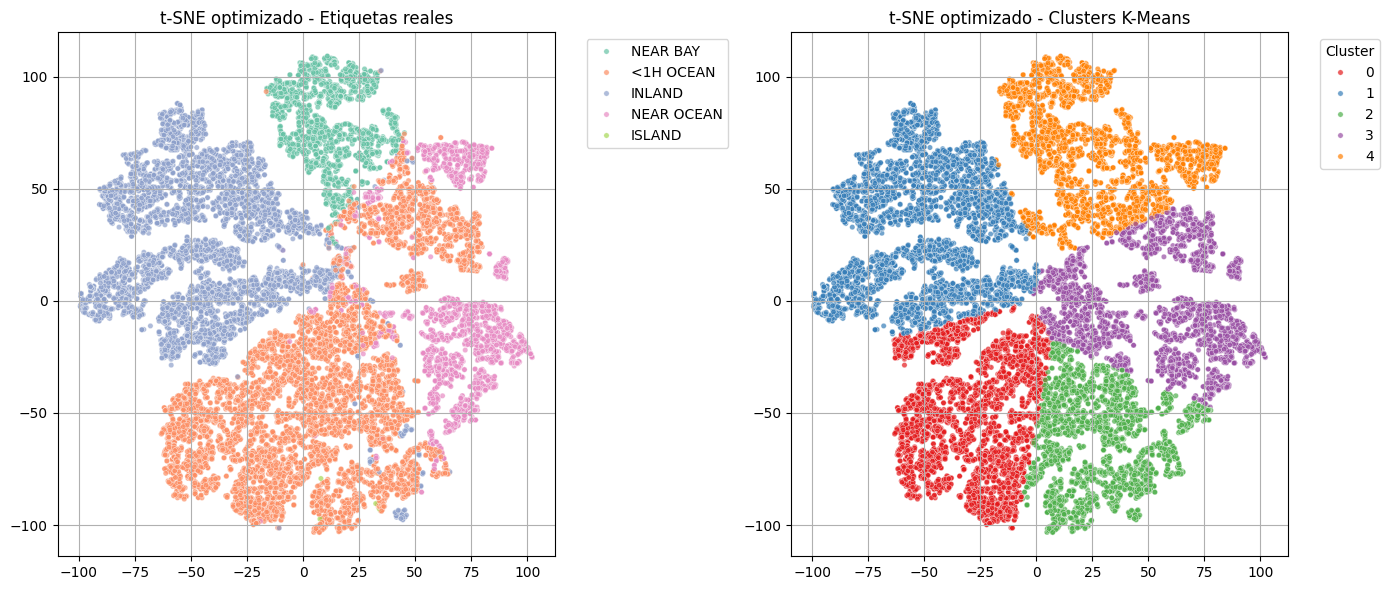

In [73]:
# ===== 1. t-SNE optimizado =====
X_full = pipeline.named_steps['preprocessor'].fit_transform(df)

tsne_opt = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=500,
    random_state=42,
    n_iter=1000
)
X_tsne_opt = tsne_opt.fit_transform(X_full)

# ===== 2. K-Means sobre t-SNE optimizado =====
n_clusters = df['ocean_proximity'].nunique()
kmeans_opt = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_opt = kmeans_opt.fit_predict(X_tsne_opt)

# ===== 3. ARI =====
true_labels = LabelEncoder().fit_transform(df['ocean_proximity'])
ari_opt = adjusted_rand_score(true_labels, clusters_opt)
print(f"ARI con t-SNE optimizado: {ari_opt:.3f}")

# ===== 4. Graficar lado a lado =====
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# a) Real
sns.scatterplot(
    ax=axes[0],
    x=X_tsne_opt[:, 0],
    y=X_tsne_opt[:, 1],
    hue=df['ocean_proximity'],
    palette='Set2',
    alpha=0.7,
    s=15
)
axes[0].set_title('t-SNE optimizado - Etiquetas reales')
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# b) Clusters
sns.scatterplot(
    ax=axes[1],
    x=X_tsne_opt[:, 0],
    y=X_tsne_opt[:, 1],
    hue=clusters_opt,
    palette='Set1',
    alpha=0.7,
    s=15
)
axes[1].set_title('t-SNE optimizado - Clusters K-Means')
axes[1].grid(True)
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [74]:
# Tabla de contingencia
tabla_opt = pd.crosstab(clusters_opt, df['ocean_proximity'])
print(tabla_opt)

# Porcentaje por fila (opcional para ver proporciones)
tabla_pct = tabla_opt.div(tabla_opt.sum(axis=1), axis=0) * 100
print("\nPorcentaje de cada categoría por cluster:")
print(tabla_pct.round(2))


ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
row_0                                                           
0                     3671     616       0         0           2
1                        1    5402       0         0           2
2                     2895      94       5         0         278
3                     1829     213       0         0        1697
4                      740     226       0      2290         679

Porcentaje de cada categoría por cluster:
ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
row_0                                                           
0                    85.59   14.36    0.00       0.0        0.05
1                     0.02   99.94    0.00       0.0        0.04
2                    88.48    2.87    0.15       0.0        8.50
3                    48.92    5.70    0.00       0.0       45.39
4                    18.81    5.74    0.00      58.2       17.26
